# Guide
In this notebook we try to train specific time series and after use Arima, as we will see later the models were not good because we don't have enough data in datasetB.

The result with the RandomForest is good.


# Preconfiguration
To execute - First create a service account and save in Google Drive, after change next data

In [ ]:
#Modify after MyDrive providing folders and file name
service_account_location = "drive/MyDrive/Ideas/movilidad/vacio-276411-service_account_for_colab.json"

#Imports

In [ ]:
pip install rtree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Pandas import
import pandas as pd
#Numpy import
import numpy as np
#Seaborn import
import seaborn as sns
#Geospatial imports
import matplotlib.pyplot as plt
import geopandas as gpd
#Import KMZ
import fiona
#Forecast time series
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
#Import for autocorrelation plots
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
#Import for arima model
from statsmodels.tsa.arima_model import ARIMA
#BIGQUERY IMPORTS
from google.cloud import bigquery #For bigquerycredentials
from google.oauth2 import service_account #For credentials


##Mount access to Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

#Set credentials as global
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]= service_account_location

# Construct a BigQuery client object.
client = bigquery.Client()

Mounted at /content/drive


# Get data

In [ ]:
query = """
SELECT * FROM `vacio-276411.mainDataset.V2_trips_grouped_all_hours`
"""
df_tripsb_grouped = client.query(query).to_dataframe()

In [ ]:
df_tripsb_grouped

,district,dateandtime,trips
0,1,2022-06-11T00:00:00z,0
1,1,2022-06-11T01:00:00z,0
2,1,2022-06-11T02:00:00z,0
3,1,2022-06-11T03:00:00z,0
4,1,2022-06-11T04:00:00z,0
...,...,...,...
27547,21,2022-08-31T19:00:00z,0
27548,21,2022-08-31T20:00:00z,0
27549,21,2022-08-31T21:00:00z,0
27550,21,2022-08-31T22:00:00z,0


In [ ]:
df_tripsb_grouped.reset_index(drop=True)

,district,dateandtime,trips
0,1,2022-06-11T00:00:00z,0
1,1,2022-06-11T01:00:00z,0
2,1,2022-06-11T02:00:00z,0
3,1,2022-06-11T03:00:00z,0
4,1,2022-06-11T04:00:00z,0
...,...,...,...
27547,21,2022-08-31T19:00:00z,0
27548,21,2022-08-31T20:00:00z,0
27549,21,2022-08-31T21:00:00z,0
27550,21,2022-08-31T22:00:00z,0


# Timeseries

Create lag

In [ ]:
#Shift method to create the lag variables
df_tripsb_grouped['trips_lag_28_days'] = df_tripsb_grouped['trips'].shift(28*24) #28 days before same hour
df_tripsb_grouped['trips_lag_14_days'] = df_tripsb_grouped['trips'].shift(14*24) #14 days before same hour
df_tripsb_grouped['trips_lag_7_days'] = df_tripsb_grouped['trips'].shift(7*24) #7 days before same hour
df_tripsb_grouped['trips_lag_1_days'] = df_tripsb_grouped['trips'].shift(1*24) # 1 day before same hour
df_tripsb_grouped['trips_lag_2_days'] = df_tripsb_grouped['trips'].shift(2*24) # 2 days before same hour
df_tripsb_grouped['trips_lag_1_hours'] = df_tripsb_grouped['trips'].shift(1) # 1 hour before
df_tripsb_grouped['trips_lag_2_hours'] = df_tripsb_grouped['trips'].shift(1) # 2 hours before
df_tripsb_grouped.head(300)

,district,dateandtime,trips,trips_lag_28_days,trips_lag_14_days,trips_lag_7_days,trips_lag_1_days,trips_lag_2_days,trips_lag_1_hours,trips_lag_2_hours
0,1,2022-06-11T00:00:00z,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2022-06-11T01:00:00z,0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,1,2022-06-11T02:00:00z,0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,1,2022-06-11T03:00:00z,0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,1,2022-06-11T04:00:00z,0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
295,1,2022-06-23T07:00:00z,1,NaN,NaN,1.0,0.0,4.0,0.0,0.0
296,1,2022-06-23T08:00:00z,0,NaN,NaN,2.0,1.0,1.0,1.0,1.0
297,1,2022-06-23T09:00:00z,1,NaN,NaN,1.0,2.0,0.0,0.0,0.0
298,1,2022-06-23T10:00:00z,2,NaN,NaN,3.0,1.0,2.0,1.0,1.0


Analyze the correlation

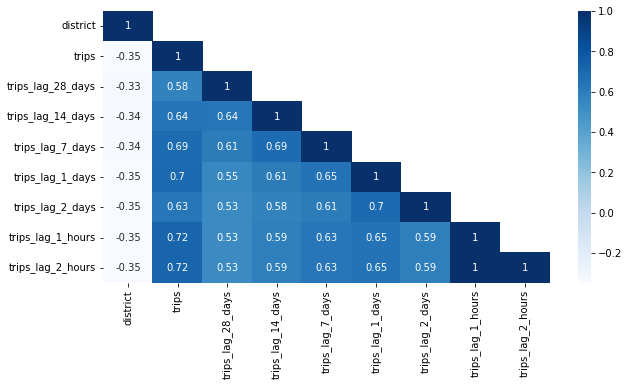

In [ ]:
corr_matrix = df_tripsb_grouped.corr()
fig = plt.figure(figsize=(10, 5))

mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False

sns.heatmap(corr_matrix, mask = mask, annot=True, cbar=True,cmap="Blues")
plt.show()

Evaluation metric

In [ ]:
def mape(y_true, y_pred):
    ape = np.abs((y_true - y_pred) / y_true)
    #ape[~np.isfinite(ape)] = 0. # VERY questionable
    ape[~np.isfinite(ape)] = 1. # pessimist estimate
    return np.mean(ape)

def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

Baseline

In [ ]:
y_pred = df_tripsb_grouped['trips']
y_true = df_tripsb_grouped['trips_lag_1_hours']

In [ ]:
result_1 = {'Method':['Baseline'],'MAPE':[mape(y_true, y_pred)],'WMAPE':[wmape(y_true, y_pred)]}
df_results = pd.DataFrame(result_1)
df_results

,Method,MAPE,WMAPE
0,Baseline,0.840448,0.577074


Spit data

In [ ]:
#Split data
#TODO: Without change this date in the future the test list will be bigger than now
#split_point = 40
split_point = '2022-08-01'
filter_train = df_tripsb_grouped['dateandtime'] < split_point
filter_valid = df_tripsb_grouped['dateandtime'] >= split_point

df_all_hours_data_train = df_tripsb_grouped[ filter_train].copy()
df_all_hours_data_valid = df_tripsb_grouped[ filter_valid ].copy()

Train model

In [ ]:
features= ['trips_lag_28_days',	'trips_lag_14_days',	'trips_lag_7_days',	'trips_lag_1_days',	'trips_lag_2_days',	'trips_lag_1_hours',	'trips_lag_2_hours']

imputer = SimpleImputer()
Xtr = imputer.fit_transform(df_all_hours_data_train[features])
ytr = df_all_hours_data_train['trips']

mdl = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=6)
mdl.fit(Xtr, ytr)

RandomForestRegressor(n_jobs=6, random_state=0)

Evaluate model

In [ ]:
Xval = imputer.transform(df_all_hours_data_valid[features])
yval = df_all_hours_data_valid['trips']

p = mdl.predict(Xval)

In [ ]:
p

array([0.31318433, 0.48093988, 0.17701442, ..., 0.31318433, 0.0812104 ,
       0.0812104 ])

In [ ]:
result_2 = {'Method':'RandomForest_1','MAPE':mape(yval,p),'WMAPE':wmape(yval, p)}
df_results = df_results.append(result_2, ignore_index = True)
df_results

,Method,MAPE,WMAPE
0,Baseline,0.840448,0.577074
1,RandomForest_1,0.768521,0.523851


Check district 4 and draw result

In [ ]:
filter_district_df_all_hours_data_train = df_all_hours_data_train['district'] == 1
filter_district_df_all_hours_data_valid = df_all_hours_data_valid['district'] == 1
filter_district_df_tripsb_grouped = df_tripsb_grouped['district'] == 1

Xval = imputer.transform(df_all_hours_data_valid[filter_district_df_all_hours_data_valid][features])
yval = df_all_hours_data_valid[filter_district_df_all_hours_data_valid]['trips']

p = mdl.predict(Xval)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


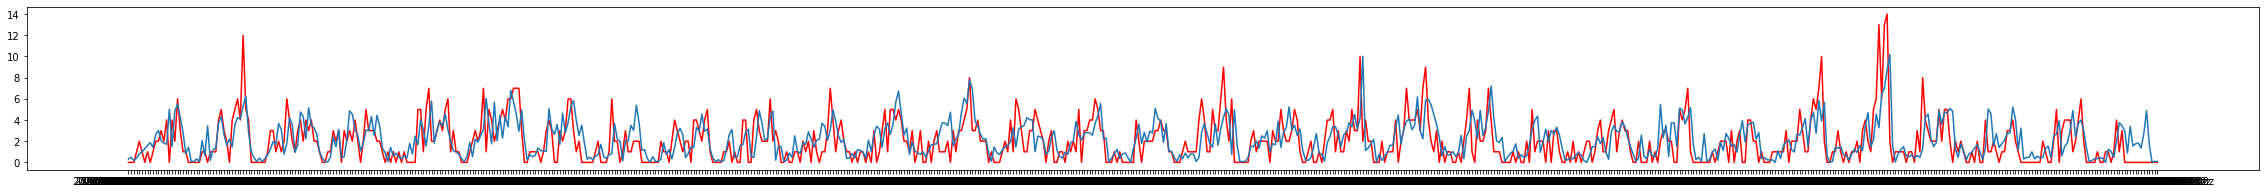

In [ ]:
fig, ax = plt.subplots(figsize=(40, 3))

#Original
xpoints = df_tripsb_grouped[filter_valid][filter_district_df_tripsb_grouped]['dateandtime']
yReal= df_tripsb_grouped[filter_valid][filter_district_df_tripsb_grouped]['trips']

#Predicted
ypoints = df_all_hours_data_valid[filter_district_df_all_hours_data_valid]['dateandtime']
yEstimation = p

plt.plot(xpoints, yReal, c='red')
plt.plot(ypoints, yEstimation)
plt.show()

In [ ]:
print('Mape for district 4' , mape(yval,p) , 'WMAPE:', wmape(yval, p), ' Mean trips: ', df_tripsb_grouped[filter_valid]["trips"].mean(), ' WMAPE percent:', wmape(yval, p)/df_tripsb_grouped[filter_valid]["trips"].mean())

Mape for district 4 0.7342095489677928 WMAPE: 0.6699256870566354  Mean trips:  2.6869239631336406  WMAPE percent: 0.24932811506706376


As we can see when the district has a low volume of data the prediction are worse than in the districts with more information.

This happend becouse the wmape is the same in all the districts but is not de same a MAPE of 1 in a data of 3 than in a data of 15

# Train a specific time series 
Train a specifict time series for this district to compare if the results could be better with a serie for every district instead of one for all

In [ ]:
#Train model
features= ['trips_lag_28_days',	'trips_lag_14_days',	'trips_lag_7_days',	'trips_lag_1_days',	'trips_lag_2_days',	'trips_lag_1_hours',	'trips_lag_2_hours']

imputer = SimpleImputer()
Xtr = imputer.fit_transform(df_all_hours_data_train[filter_district_df_all_hours_data_train][features])
ytr = df_all_hours_data_train[filter_district_df_all_hours_data_train]['trips']

mdl = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=6)
mdl.fit(Xtr, ytr)
#Evaluate model

Xval = imputer.transform(df_all_hours_data_valid[filter_district_df_all_hours_data_valid][features])
yval = df_all_hours_data_valid[filter_district_df_all_hours_data_valid]['trips']

p = mdl.predict(Xval)
print('Mape for district 1' , mape(yval,p) , 'WMAPE:', wmape(yval, p), ' Mean trips: ', df_tripsb_grouped[filter_valid]["trips"].mean(), ' WMAPE percent:', wmape(yval, p)/df_tripsb_grouped[filter_valid]["trips"].mean())

Mape for district 1 0.7349293709669215 WMAPE: 0.7101749821265588  Mean trips:  2.6869239631336406  WMAPE percent: 0.2643078076903647


In [ ]:
#Calculate error
result_3 = {'Method':'RandomForest_1_DISC_1','MAPE':mape(yval,p),'WMAPE':wmape(yval, p)}
df_results = df_results.append(result_3, ignore_index = True)
df_results

,Method,MAPE,WMAPE
0,Baseline,0.840448,0.577074
1,RandomForest_1,0.768521,0.523851
2,RandomForest_1_DISC_1,0.734929,0.710175


The result of the specific time series is as worst as with all the data

This doesn`t means that a global time series is as good as one for each district becouse maybe the data is not as good / as enought to have a better effect a individual time series

#Arima


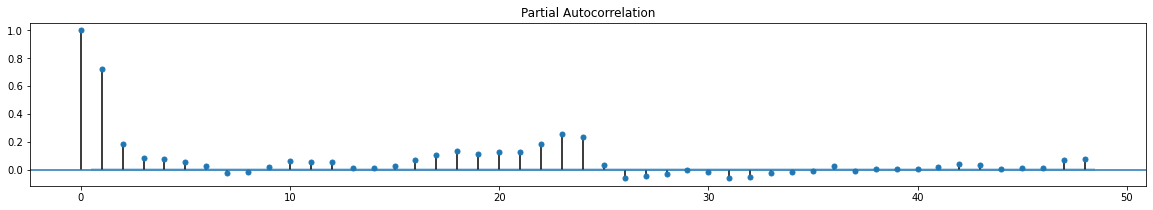

In [ ]:
fig, ax = plt.subplots(figsize=(20, 3))
plot_pacf(df_tripsb_grouped.trips, ax=ax, lags=2*24)
plt.show()

Estuding the Partial Autocorrelation select p as 24

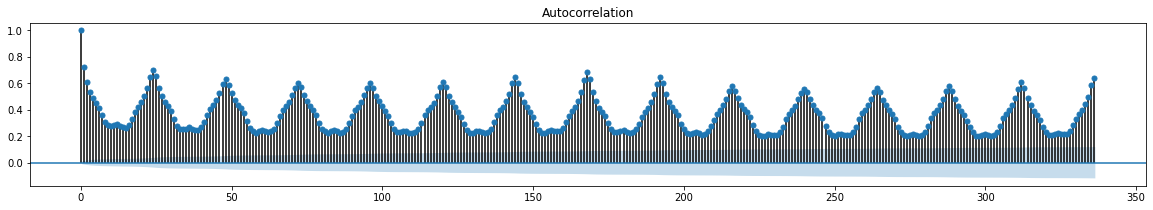

In [ ]:
fig, ax = plt.subplots(figsize=(20, 3))
plot_acf(df_tripsb_grouped.trips, ax=ax, lags=2*7*24)
plt.show()

Estuding the Autocorrelation select q as 24*7=168

In [ ]:
#For arima model we only need one variable 'rides', the variable we want to predict
data_arima = df_tripsb_grouped['trips']
#Now only for district 1
train_arima= df_tripsb_grouped[filter_train][filter_district_df_all_hours_data_train]['trips']
valid_arima= df_tripsb_grouped[filter_valid][filter_district_df_all_hours_data_valid]['trips']

Next step takes a long long time to execute

In [ ]:
#Create the model with the train data
arima_model = ARIMA(train_arima, order=(24,0,10))
#Fit the model
model_fit = arima_model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
#Print of the summary of results
print(model_fit.summary())

In [ ]:
#TODO: Analyze if are wihte noise

In [ ]:
#obtain predictions and interval confidence of them
predictions, se, confidence = model_fit.forecast(len(valid_arima),alpha = 0.05) #95% confidence
predictions = pd.Series(predictions, index=valid_arima.index)
lower_band = pd.Series(confidence[:,0], index = valid_arima.index)
upper_band = pd.Series(confidence[:,1], index=valid_arima.index)

#Plot of predictions vs real demand and the interval of 95% confidence
plt.figure(figsize=(16,5))
plt.plot(valid_arima, label = 'demand')
plt.plot(predictions, label ='predictions')
plt.fill_between(lower_band.index, lower_band,upper_band, color='k', alpha=.15)
plt.legend()
plt.show()

In [ ]:
#Calculate error
result_3 = {'Method':'Arima_96_0_96_ONLY_1','MAPE':mape(valid_arima,predictions),'WMAPE':wmape(valid_arima, predictions)}
df_results = df_results.append(result_3, ignore_index = True)
df_results

# Usar WAPE en lugar de RMSE
"Muchos clientes minoristas trabajan con datasets dispersos, donde la mayoría de sus SKUs se venden con poca frecuencia. Para la mayoría de los datos históricos, la demanda es 0. Para estos datasets, es importante tener en cuenta la escala de la demanda total, haciendo que wQL y WAPE sean una mejor métrica que RMSE para evaluar datasets dispersos. La métrica RMSE no toma en cuenta la escala de la demanda total y devuelve un valor RMSE más bajo considerando el número total de puntos de datos históricos y el número total de SKUs, dando una falsa sensación de seguridad de que se tiene un modelo preciso."

Fuente: https://aws.amazon.com/es/blogs/aws-spanish/midiendo-la-precision-de-modelos-de-forecast-para-optimizar-sus-objetivos-de-negocio-con-amazon-forecast/ apartado "Weighted absolute percentage error (WAPE)"